[Russia](https://coronavirus-monitor.ru/coronavirus-v-rossii/)<br>
[Moscow](https://coronavirus-monitor.ru/coronavirus-v-moskve/)<br>
[Saint Petersburg](https://coronavirus-monitor.ru/coronavirus-v-sankt-peterburge/)<br>
[Komi](https://coronavirus-monitor.ru/coronavirus-v-respublike-komi/)<br>
[2020 coronavirus pandemic in Russia](https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Russia)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import math

PATH_DB = '/media/l3m/LinuxFilesBig/1-datasets/COVID-19/'

<br>

### Load and prepare data

In [2]:
# Load data from disk in Notebook
data_ac = pd.read_csv(PATH_DB+'COVID-19-Russia.csv')

# check result
print(data_ac.shape)
data_ac.head(3)

(149, 5)


,Territory,Date,Confirmed,Deaths,Recovered
0,Russia,03/03/20,7,0.0,4.0
1,NaN,03/04/20,7,0.0,4.0
2,NaN,03/05/20,11,0.0,4.0


In [3]:
# Fill blanks in the territory column by upstream values
data_ac['Territory'] = data_ac['Territory'].fillna(method='ffill')

# Convirt content of 'Date'-column to date format
data_ac['Date'] = pd.to_datetime(data_ac['Date'])

print(data_ac.shape)
data_ac.head(3)

(149, 5)


,Territory,Date,Confirmed,Deaths,Recovered
0,Russia,2020-03-03,7,0.0,4.0
1,Russia,2020-03-04,7,0.0,4.0
2,Russia,2020-03-05,11,0.0,4.0


<br>

### Create a table revealing of new cases

In [4]:
# Till now DataFrame contains total number of cases.
# Change it to the number of new cases per day (calculate it as difference b/w neighbouring rows)

data_dynamics = pd.concat([data_ac[['Territory', 'Date']],
                           data_ac[['Confirmed', 'Deaths', 'Recovered']].diff()
                          ], axis='columns') \
                  .reset_index(drop=True)

print(data_dynamics.shape)
data_dynamics.head(3)

(149, 5)


,Territory,Date,Confirmed,Deaths,Recovered
0,Russia,2020-03-03,NaN,NaN,NaN
1,Russia,2020-03-04,0.0,0.0,0.0
2,Russia,2020-03-05,4.0,0.0,0.0


In [5]:
# Now the first row (earliest day of observation) for each country contains garbage.
# So, delete the earliest data for each country

def delete_earliest_data(gr):
    gr.drop(gr.index[0], inplace=True)
    return gr
    
data_dynamics = data_dynamics.groupby(['Territory']) \
                             .apply(delete_earliest_data) \
                             .reset_index(drop=True)


# Fill blanks in the 'Deaths' and 'Recovered' columns by -1
data_ac[['Deaths', 'Recovered']] = data_ac[['Deaths', 'Recovered']].fillna(-1).astype('int')
data_dynamics[['Deaths', 'Recovered']] = data_dynamics[['Deaths', 'Recovered']].fillna(-1).astype('int')

# Correct type in 'Confirmed' column
data_ac['Confirmed'] = data_ac['Confirmed'].astype('int')
data_dynamics['Confirmed'] = data_dynamics['Confirmed'].astype('int')


print(data_dynamics.shape)
data_dynamics.head(3)

(145, 5)


,Territory,Date,Confirmed,Deaths,Recovered
0,Komi,2020-03-01,0,0,0
1,Komi,2020-03-02,0,0,0
2,Komi,2020-03-03,0,0,0


<br>

### Create graphs with raw and smooth data

In [6]:
def smooth_df(df):
    
    def smooth_column_values(column):
        ls = list(column)
        lng = len(ls)

        smoothed_values = [] 
        
        smoothed_values.append(round((ls[0]*2 + ls[1]) / 3, 2))
        smoothed_values.extend([round((ls[i-1] + ls[i] + ls[i+1]) / 3, 2) for i in range(1, lng-1)])
        smoothed_values.append(round((ls[lng-2] + ls[lng-1]*2) / 3, 2))
    
        return smoothed_values

    df_smoothed = df.copy()
    for col_name in ['Confirmed', 'Deaths', 'Recovered']:
        df_smoothed[col_name] = smooth_column_values(df_smoothed[col_name])
        
    return df_smoothed

In [7]:
def build_graph(df, territory_name, last_date, number_of_days=30):
    # extract DataFrame with data only about given country
    df_territory = df[df['Territory'] == territory_name]
    
    # create DataFrame with smoothed data about given country
    df_smoothed = smooth_df(df_territory)
    
    # calculate the first date for showing in the graph
    first_date = last_date + datetime.timedelta(days=-number_of_days+1)


    # create and show graph with raw and smoothed data
    def create_and_show_graph(df, *, title_name = None):
        
        # reduce DataFrame, so it contains only data necessary for displaying
        df = df[(df['Date'] >= first_date) &
                (df['Date'] <= last_date)]

        # determine colors for graph
        if territory_name == 'Russia':
            colors_graph = ['#D0810F', '#C07800']
        else:
            colors_graph = ['#5398C6', '#1F77B4']
    
        # create and show plot
        plt.title(title_name)
        plt.margins(x=0.003)
        plt.xticks(rotation='vertical')
        plt.grid(axis='y', color='limegreen', linewidth=0.15, zorder = 1)

        plt.bar(df['Date'].dt.strftime('%b-%d'), df['Confirmed'],
                width=1, color=colors_graph, zorder = 2)

        plt.show()
    
    create_and_show_graph(df_territory, title_name=territory_name+' (raw data, cases/day)')
    create_and_show_graph(df_smoothed, title_name=territory_name+' (smoothed data, cases/day)')

In [8]:
plt.rcParams['figure.figsize'] = (20, 6)
plt.rcParams['font.size'] = 14

LAST_DATE_GLOBAL = data_ac['Date'].max()  # LAST_DATE_GLOBAL = datetime.datetime(2020, 3, 25)
NUMBER_OF_DAYS_GLOBAL = 30

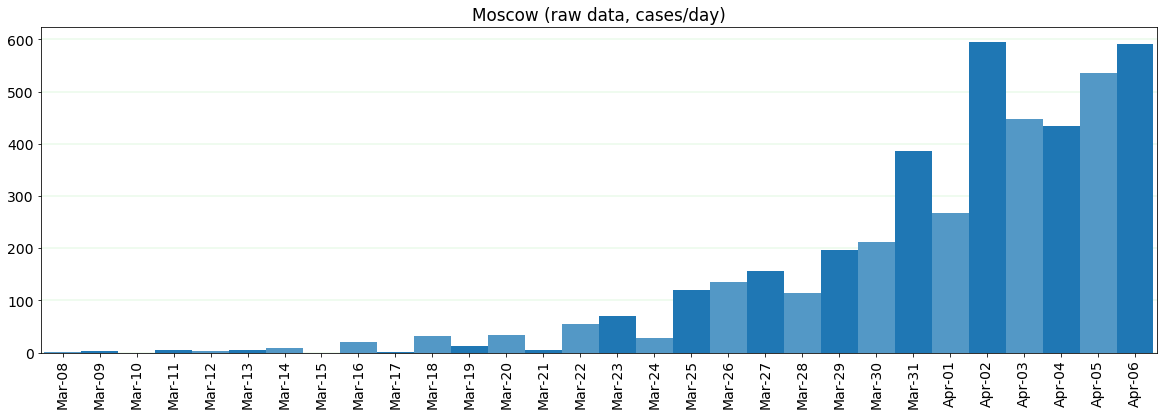

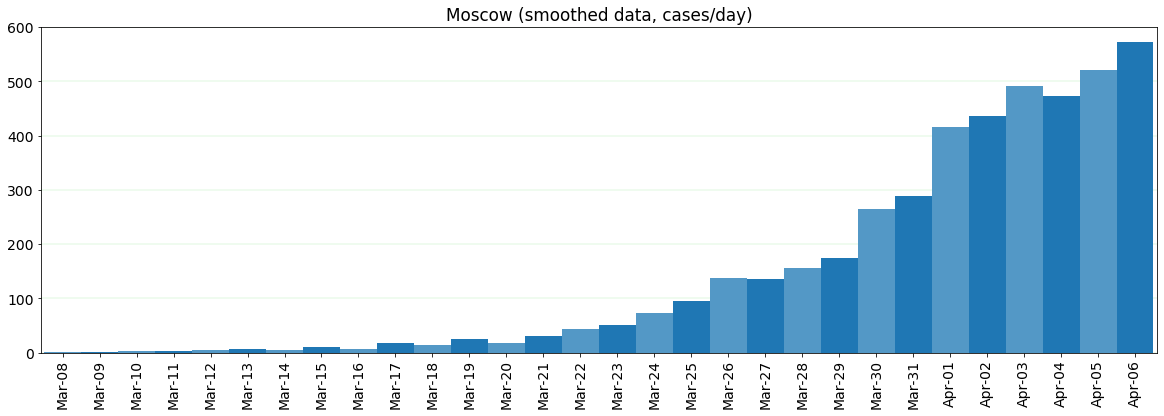

In [9]:
# for city
territory_name = 'Moscow'
last_date = LAST_DATE_GLOBAL
number_of_days = NUMBER_OF_DAYS_GLOBAL

build_graph(data_dynamics, territory_name, last_date, number_of_days)

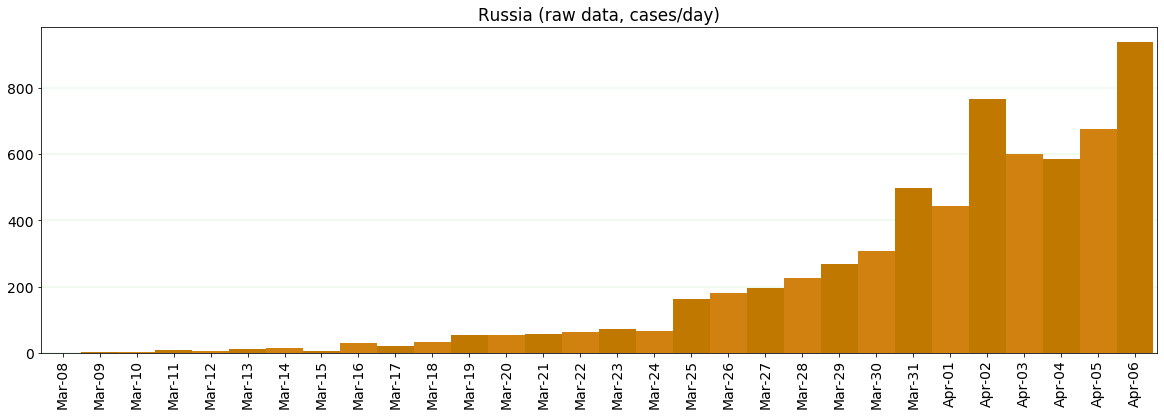

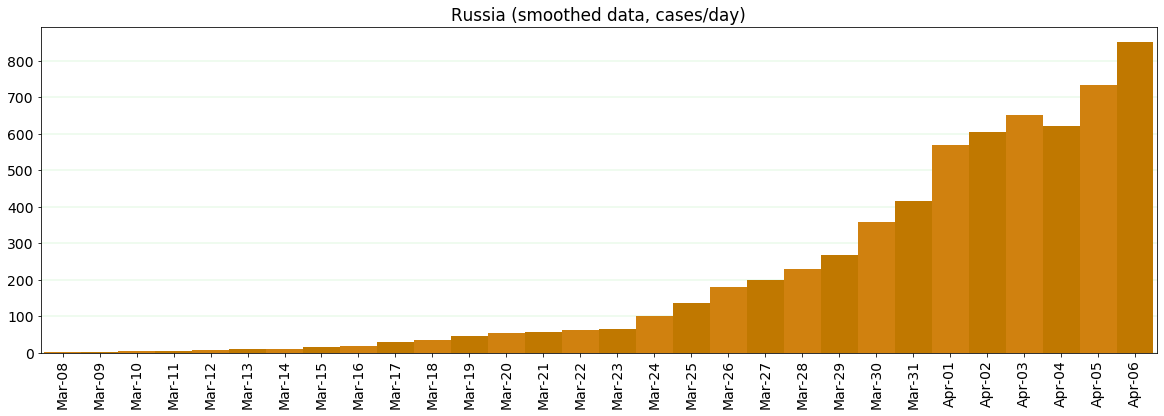

In [10]:
# for country
last_date = LAST_DATE_GLOBAL
number_of_days = NUMBER_OF_DAYS_GLOBAL

build_graph(data_dynamics, "Russia", last_date, number_of_days)

<br>

### Sophisticated graph

In [11]:
plt.rcParams['figure.figsize'] = (20, 8)
plt.rcParams['font.size'] = 14

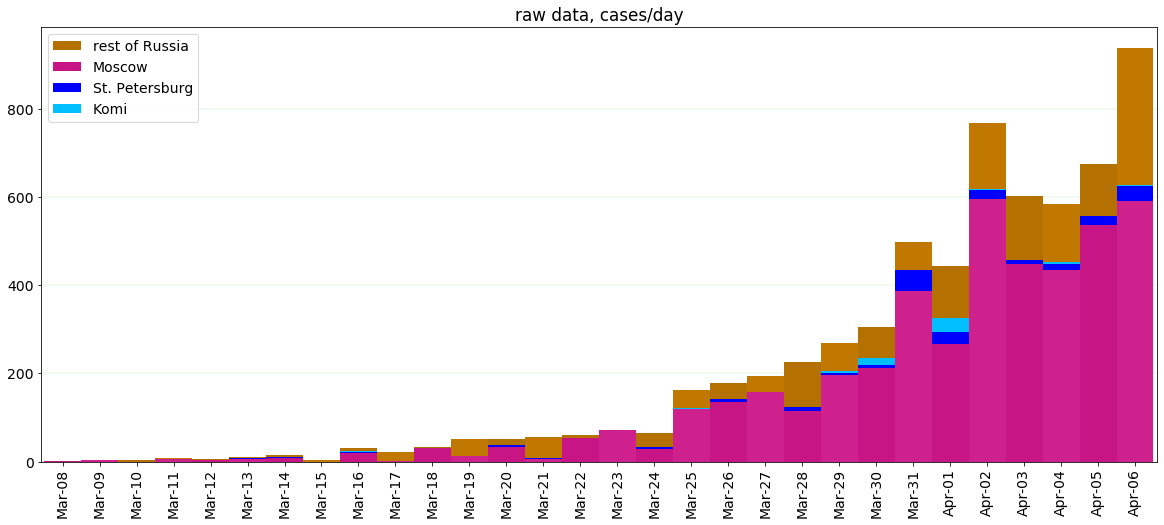

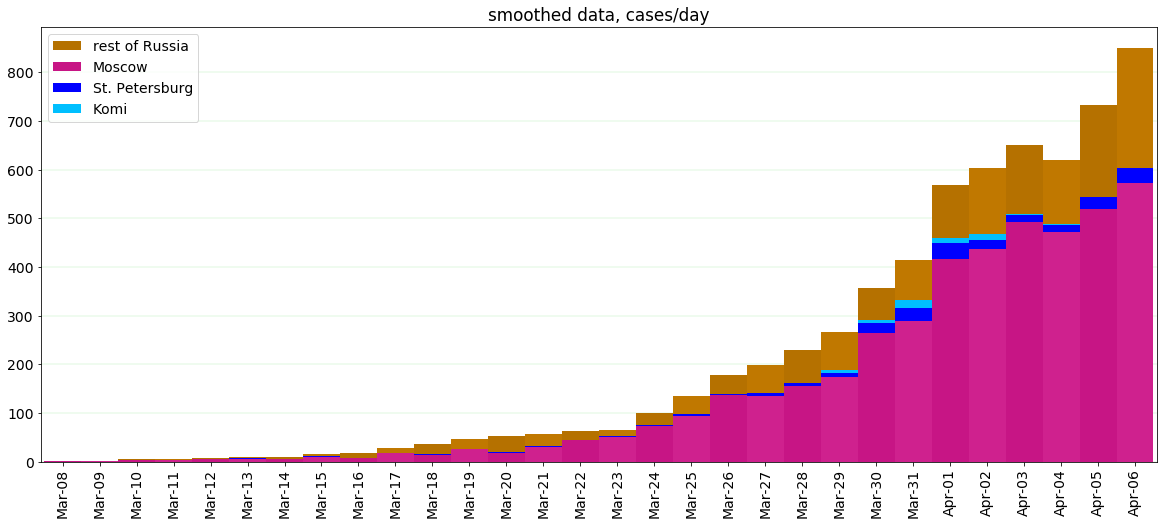

In [12]:
def build_graph_sophisticated(df, territories, number_of_days=30, last_date_max=datetime.date.today()):
  
    # calculate the last and the first date for displaying
    last_date = df[df['Territory'].isin(territories)] \
                      .groupby(['Territory']) \
                      .max() \
                      ['Date'].max()
    last_date = min(last_date, last_date_max)
    
    first_date = df[df['Territory'].isin(territories)] \
                      .groupby(['Territory']) \
                      .min() \
                      ['Date'].min()
    first_date = max(first_date, last_date + datetime.timedelta(days=-number_of_days+1))

    
    # create combined DataFrame with info about each territory
    df_combined = df[df['Territory'] == territories[0]] \
                    [['Date', 'Confirmed']] \
                    .set_index('Date') \
                    .rename(columns={'Confirmed': territories[0]})
    
    for territory in territories[1:]:
        df_ter = df[df['Territory'] == territory] \
                   [['Date', 'Confirmed']] \
                   .set_index('Date') \
                   .rename(columns={'Confirmed': territory})
        df_combined = pd.concat([df_combined, df_ter], axis='columns', sort=False)
    
    df_combined = df_combined.sort_index() \
                             .fillna(0) \
                             .astype('int')

    
    # create variety of df_combined with smoothed data for the second graph
    def smooth_column_values(column):
        ls = list(column)
        lng = len(ls)

        smoothed_values = [] 
        
        smoothed_values.append(round((ls[0]*2 + ls[1]) / 3, 2))
        smoothed_values.extend([round((ls[i-1] + ls[i] + ls[i+1]) / 3, 2) for i in range(1, lng-1)])
        smoothed_values.append(round((ls[lng-2] + ls[lng-1]*2) / 3, 2))
    
        return smoothed_values
    
    df_combined_smoothed = df_combined.copy()
    for col_name in territories:
        df_combined_smoothed[col_name] = smooth_column_values(df_combined_smoothed[col_name])
    
    
    # create and show graph with raw and smoothed data
    def create_and_show_graph(df, *, title_name = None):
        df = df[(df.index >= first_date) &
                (df.index <= last_date)]
        
        colors_city = [['#C71585', '#CF218E'], 'blue', 'deepskyblue', 'yellow', 'green']
        
        plt.margins(x=0.003)
        plt.xticks(rotation='vertical')
        plt.grid(axis='y', color='limegreen', linewidth=0.15, zorder = 1)

        plt.bar(df.index.strftime('%b-%d'), df[territories[0]],
             width=1, color=['#B57100', '#C07800'], zorder = 2, label=f'rest of {territories[0]}')

        for i, territory in enumerate(territories[1:], 2):
            plt.bar(df.index.strftime('%b-%d'), df[territories[1:i]].sum(axis=1),
                width=1, color=colors_city[i-2], zorder = 10-i, label=territory)

        plt.legend()
        plt.title(title_name)
        plt.show()

    create_and_show_graph(df_combined, title_name='raw data, cases/day')
    create_and_show_graph(df_combined_smoothed, title_name='smoothed data, cases/day')


# datetime.datetime(2020, 3, 25)   # date = datetime.date.today()
build_graph_sophisticated(data_dynamics, ['Russia', 'Moscow', 'St. Petersburg', 'Komi'], 30)

<br>

### Comparison of several cities

In [13]:
plt.rcParams['figure.figsize'] = (20, 8)  # plt.rc('figure', figsize=(20, 8))
plt.rcParams['font.size'] = 14             # plt.rc('font', size=14)

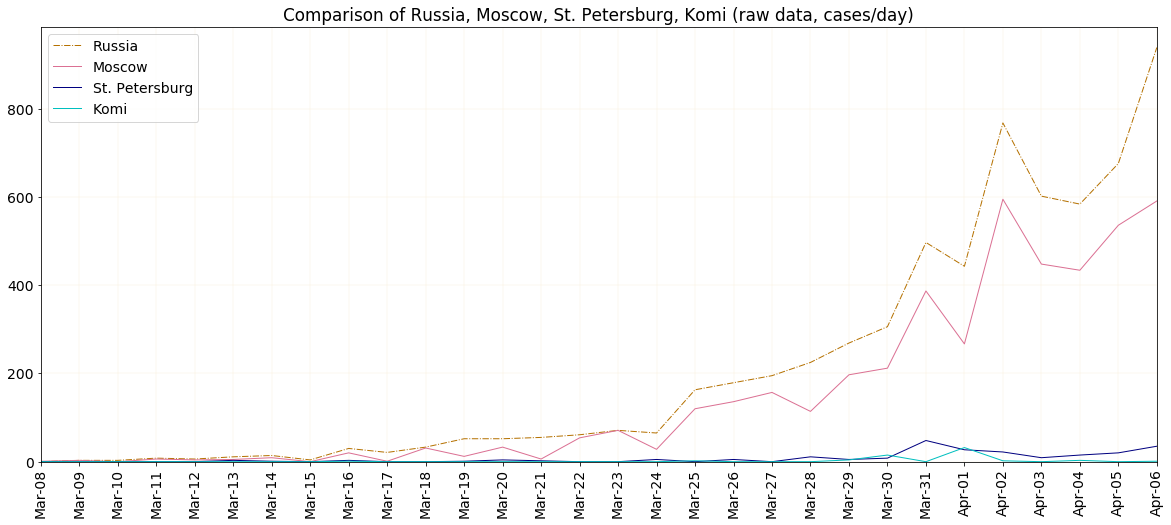

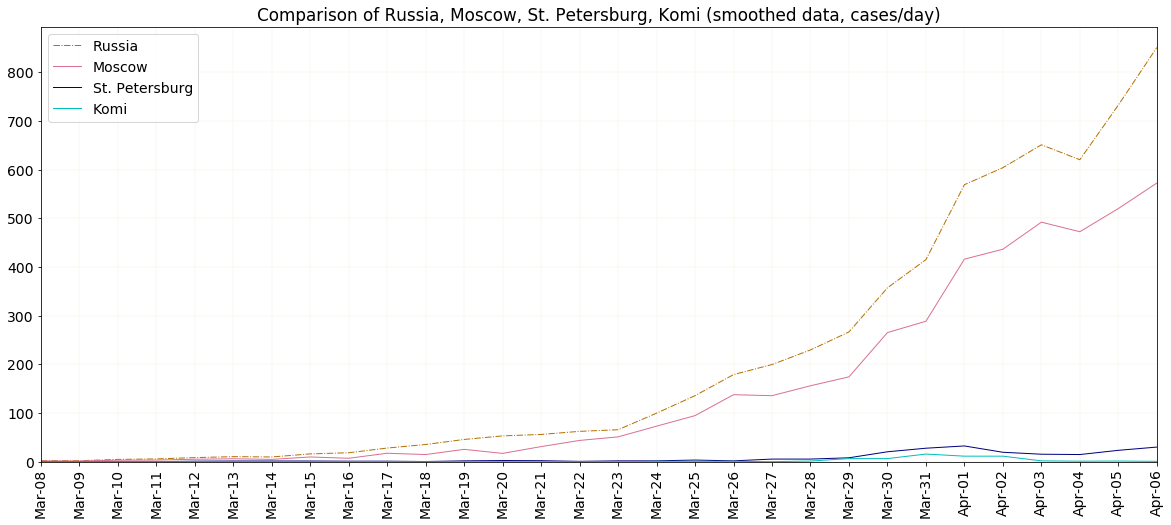

In [14]:
# for raw data, linear scale

places = ['Russia', 'Moscow', 'St. Petersburg', 'Komi']
colors = ['#B57100', 'palevioletred', 'navy', 'c']
styles = ['-.', '-', '-', '-']

last_date = LAST_DATE_GLOBAL
number_of_days = NUMBER_OF_DAYS_GLOBAL

# calculate the first date for showing in the graph
first_date = last_date + datetime.timedelta(days=-number_of_days+1)


# create and show graph with raw and smoothed data
def create_and_show_graph(df, *, is_smoothed=False, title_name = None):
    for i, place_name in enumerate(places):
        if is_smoothed:
            df_place = smooth_df(df[df['Territory'] == place_name])
        else:
            df_place = df[df['Territory'] == place_name]
            
        df_place = df_place[(df_place['Date'] >= first_date) &
                            (df_place['Date'] <= last_date)]    
            
        plt.plot(df_place['Date'].dt.strftime('%b-%d'), df_place['Confirmed'],
                 color=colors[i], linestyle=styles[i], linewidth=1, label=place_name)

    plt.title(title_name)
    plt.margins(x=0)
    plt.ylim(0)
    plt.xticks(rotation='vertical')
    plt.grid(color='wheat', linewidth=0.2)
    plt.legend(loc='upper left')
    plt.show()


create_and_show_graph(data_dynamics,
                      is_smoothed=False,
                      title_name=f"Comparison of {', '.join(places)} (raw data, cases/day)")

create_and_show_graph(data_dynamics,
                      is_smoothed=True,
                      title_name=f"Comparison of {', '.join(places)} (smoothed data, cases/day)")

<br>
<br>

In [15]:
# ['#B57100', '#C07800'] - light brown combination
# ['#8D5800', '#9A6101'] - dark brown combination
# ['#8D5800', '#8D6B00', '#956F2F', '#A26B0F', '#9A6101', '#A75B22', '#A76900'] - brown*7
# ['#727100', '#6A6900'] - green combination
# ['#C71585', '#CF218E'] - red combination
# ['#B57100', '#C07800'] - red combination (2)